## PCA and Kernel PCA
### Toy Problems Rozanoff 2025
 
This notebook explores toy problems involving PCA and kernel PCA methods. While these dimension reduction methods are generally used for data classification and visualisation, their role in Rozanoff 2025 is to reduce problem dimensionality so as to optimise the performance of subsequent ML algorithms like GPR and MLP.

### 1. Import Required Libraries


In [ ]:
import numpy as np            
import pandas as pd                    
import matplotlib.pyplot as plt         

# Import machine learning libraries
from sklearn.decomposition import PCA           
from sklearn.preprocessing import StandardScaler 
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# further imports for kernel PCA
from itertools import accumulate
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# inline plotting
%matplotlib inline 

### 2. PCA Classification (Breast Cancer dataset)

#### 2a. Data Preparation

In [2]:
# Load the breast cancer dataset from sklearn
breast = load_breast_cancer()
breast_data = breast.data                    # Features: (569 samples, 30 features)
breast_labels = breast.target                # Labels: 0=Benign, 1=Malignant
labels = np.reshape(breast_labels, (569, 1)) # Reshape labels to column vector

# Combine features and labels into a single array
final_breast_data = np.concatenate([breast_data, labels], axis=1)

# Convert numpy array to pandas DataFrame for easier manipulation
breast_dataset = pd.DataFrame(final_breast_data)

# Get feature names from the dataset
features = breast.feature_names
features_labels = np.append(features, 'label')  # Add 'label' column name

# Assign column names to the dataframe
breast_dataset.columns = features_labels

# Display first 5 rows
breast_dataset.head()

# Replace numeric labels with more interpretable text using the recommended approach
breast_dataset['label'] = breast_dataset['label'].replace(0, 'Benign')      # 0 → Benign
breast_dataset['label'] = breast_dataset['label'].replace(1, 'Malignant')   # 1 → Malignant

#### 2b. Data refinement

In [19]:
x = breast_dataset.loc[:, features].values
x = StandardScaler().fit_transform(x) # normalizing the features

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_breast = pd.DataFrame(x,columns=feat_cols)

#### 2c. PCA and visualisation

Explained variability per principal component: [0.44272026 0.18971182]


<Figure size 640x480 with 0 Axes>

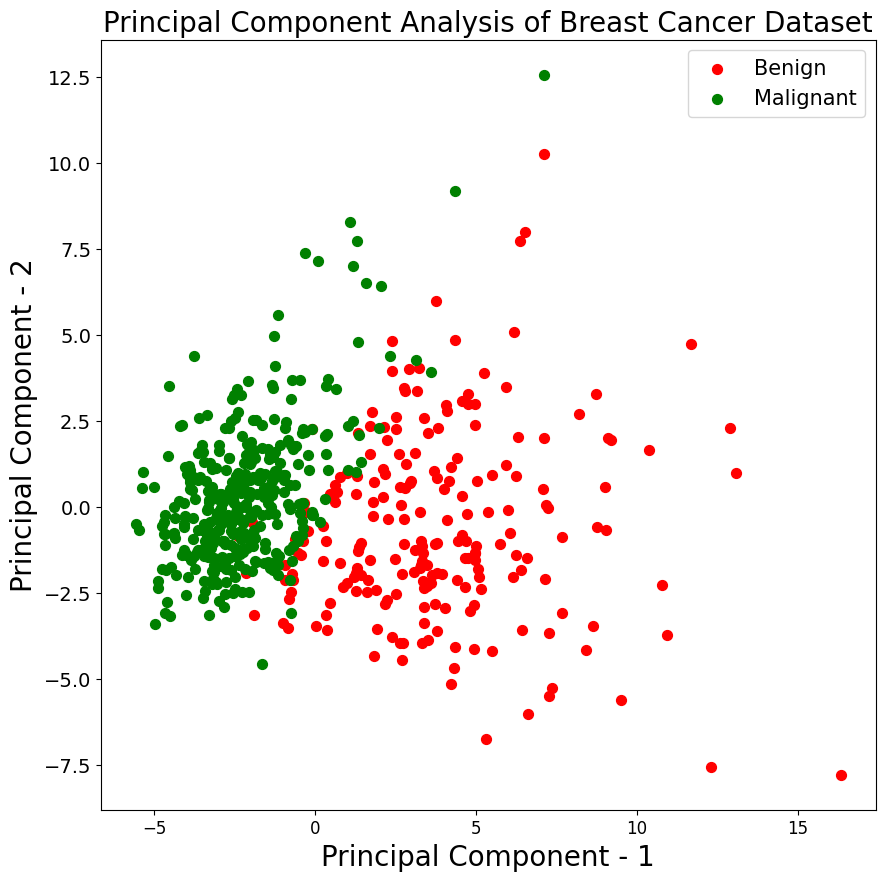

In [4]:
# dimension reduction
pca_breast = PCA(n_components=2)
principalComponents_breast = pca_breast.fit_transform(x)

principal_breast_Df = pd.DataFrame(data = principalComponents_breast
             , columns = ['principal component 1', 'principal component 2'])

print('Explained variability per principal component: {}'.format(pca_breast.explained_variance_ratio_))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = ['Benign', 'Malignant']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = breast_dataset['label'] == target
    plt.scatter(principal_breast_Df.loc[indicesToKeep, 'principal component 1']
               , principal_breast_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})


#### 3. PCA + Linear Regression (mtcars dataset)

#### 3a. Data preparation

In [20]:
# define URL where data is located
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/mtcars.csv"

# read in data
data_full = pd.read_csv(url)

# select subset of data
data = data_full[["mpg", "disp", "drat", "wt", "qsec", "hp"]]

# view first six rows of data
data[0:6]

,mpg,disp,drat,wt,qsec,hp
0,21.0,160.0,3.90,2.620,16.46,110
1,21.0,160.0,3.90,2.875,17.02,110
2,22.8,108.0,3.85,2.320,18.61,93
3,21.4,258.0,3.08,3.215,19.44,110
4,18.7,360.0,3.15,3.440,17.02,175
5,18.1,225.0,2.76,3.460,20.22,105


#### 3b. PCA and Regression

Text(0.5, 1.0, 'hp')

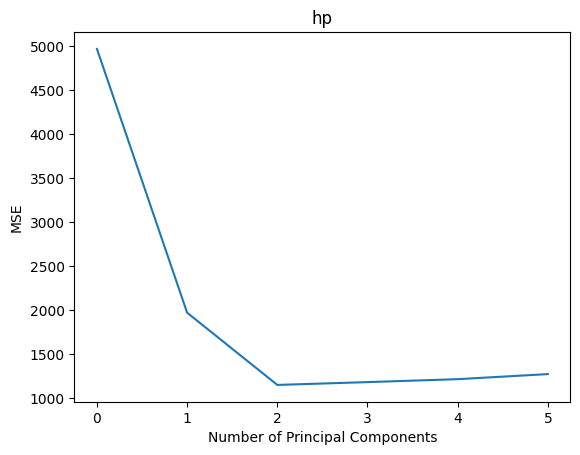

In [7]:
#define predictor and response variables
X = data[["mpg", "disp", "drat", "wt", "qsec"]]
y = data[["hp"]]

#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

#### 3c. Evaluation of performance

In [8]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


array([69.83, 89.35, 95.88, 98.95, 99.99])

#### 3d. Training and RMSE

In [9]:
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#scale the training and testing data
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:1]

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:1], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

np.float64(40.209642107611515)

#### 3e. RMSE performance as a function of pca_variance

In [ ]:
# Define different variance thresholds to test
pca_variances = [0.85, 0.95, 0.99]

# Store results
mtcars_results = []

# Train and evaluate for each variance
for variance_threshold in pca_variances:
    
    # Create PCA with variance threshold
    pca_test = PCA(n_components=variance_threshold)
    
    # Fit PCA on scaled training data and transform both sets
    X_reduced_train = pca_test.fit_transform(scale(X_train))
    X_reduced_test = pca_test.transform(scale(X_test))
    
    # Get actual number of components and variance retained
    n_components = pca_test.n_components_
    explained_var = np.sum(pca_test.explained_variance_ratio_)
    
    # Train linear regression model
    regr = LinearRegression()
    regr.fit(X_reduced_train, y_train)
    
    # Make predictions and calculate MSE
    pred = regr.predict(X_reduced_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    
    # Store results
    mtcars_results.append({
        'Variance Threshold': f"{variance_threshold*100:.0f}%",
        'N Components': n_components,
        'Variance Retained': f"{explained_var:.4f}",
        'MSE': f"{mse:.4f}",
        'RMSE': f"{rmse:.4f}"
    })


# ==================== CREATE RESULTS DATAFRAME ====================
mtcars_results_df = pd.DataFrame(mtcars_results)
print(mtcars_results_df.to_string(index=False))


Variance Threshold  N Components Variance Retained      MSE    RMSE
               85%             2            0.8956 898.4328 29.9739
               95%             3            0.9641 879.8577 29.6624
               99%             4            0.9921 921.4788 30.3559


### 4. Kernel PCA

#### 4a. Setup

In [ ]:
# Surpress warnings from using older version of sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

#### 4b. Function to plot projection onto vector

In [23]:
def plot_proj(A,v,y,name=None):

    plt.scatter(A[:,0],A[:,1],label='data',c=y,cmap='viridis')
    
    #plt.plot(np.linspace(A[:,0].min(),A[:,0].max()),np.linspace(A[:,1].min(),A[:,1].max())*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5,label=name)   
    plt.plot(np.linspace(-1,1),np.linspace(-1,1)*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5,label=name)  
    # Run through all the data

    for i in range(len(A[:,0])-1):
        #data point 
        w=A[i,:]

        # projection
        cv = (np.dot( A[i,:],v))/np.dot(v,np.transpose(v))*v

        # line between data point and projection
        plt.plot([A[i,0],cv[0]],[A[i,1],cv[1]],'r--',linewidth=1.5)
    plt.plot([A[-1,0],cv[0]],[A[-1,1],cv[1]],'r--',linewidth=1.5,label='projections' )
    plt.legend()
    plt.show()



#### Kernel PCA concept
Kernel PCA maps data into higher dimensional space then performs PCA.

#### 4c. Set up toy dataset

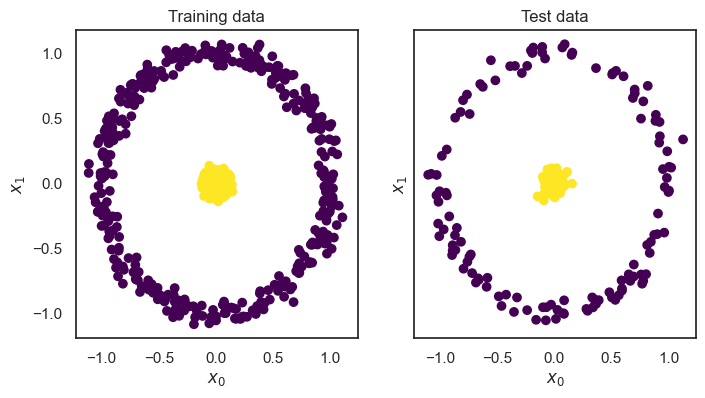

In [ ]:
# setup make_circles toy dataset

from sklearn.datasets import make_circles

# Create the toy dataset
# X is the feature matrix, y is the labels
# factor controls the size ratio between the two circles
X, y = make_circles(n_samples=1000, factor=0.01, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Visualize the data
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='viridis')
train_ax.set_xlabel("$x_{0}$")
train_ax.set_ylabel("$x_{1}$")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,cmap='viridis')
test_ax.set_xlabel("$x_{0}$")
test_ax.set_ylabel("$x_{1}$")
test_ax.set_title("Test data")
plt.show()

Samples from each class cannot be linearly separated.

#### 4d. Try PCA

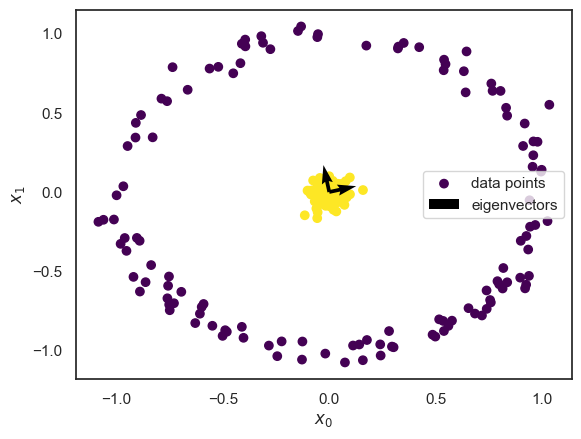

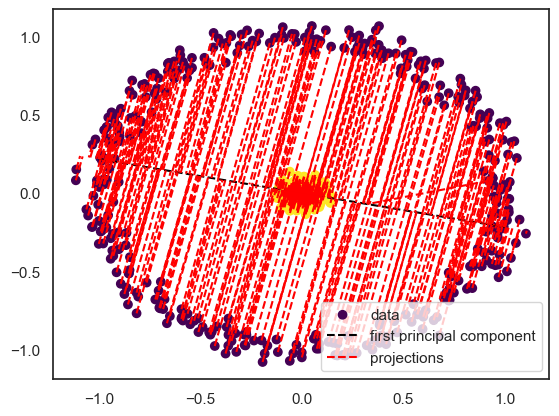

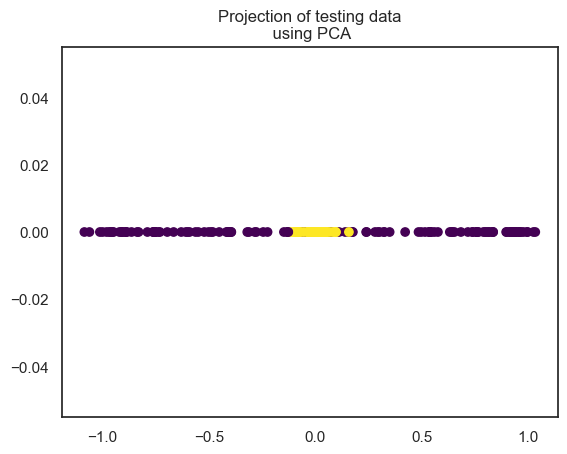

In [27]:
# Fit on a PCA object
pca = PCA(n_components=2)
score_pca = pca.fit(X_train).transform(X_test)

plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,label="data points", cmap='viridis')
plt.quiver([0,0],[0,0], pca.components_[0,:], pca.components_[1,:], label="eigenvectors")
plt.xlabel("$x_{0}$")
plt.ylabel("$x_{1}$")
plt.legend(loc='center right')
plt.show()

plot_proj(X_train,pca.components_[0,:],y_train,"first principal component")

plt.scatter(score_pca [:,0],np.zeros(score_pca[:,0].shape[0]),c=y_test,cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.show()

The data looks isotropic i.e. independent of coordinate system. Data symmetry means variane is equal on each side. As a result, PCA will not help to classify the data.

#### 4e. Use Logistic Regression as a performance indicator

In [28]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression().fit(X_train, y_train)
print(str.format("Test set  mean accuracy score for for PCA: {}", lr.score(X_test, y_test)))

Test set  mean accuracy score for for PCA: 0.496


#### 4f. Kernel PCA

Both RBF (radial basis function) and polynomial kernels are available.  
RBF is used here, and $\sigma$ is the kernel coefficient for RBF, poly and sigmoid kernels.

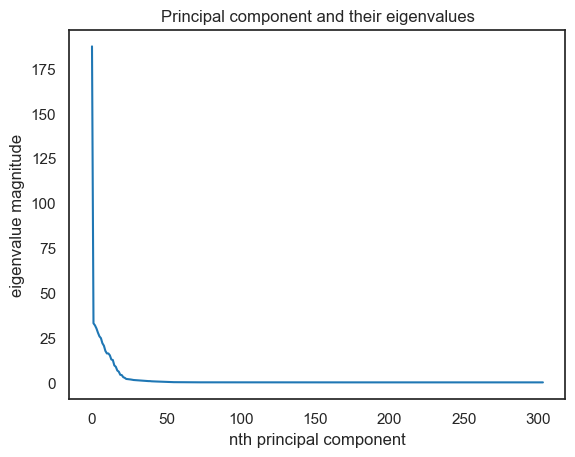

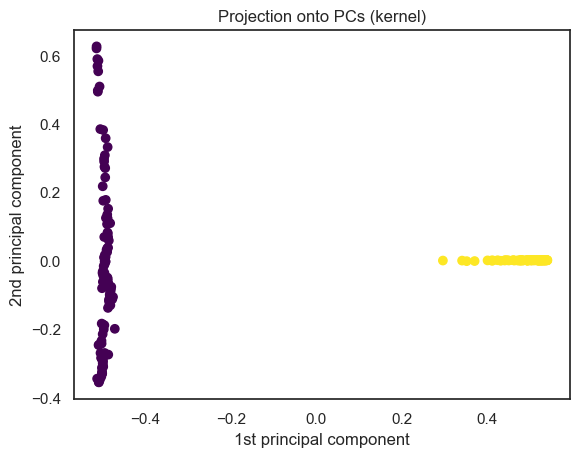

Test set mean accuracy score for kernel PCA: 1.0


In [33]:
kernel_pca = KernelPCA( kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1)
kernel_pca.fit(X_train)
score_kernel_pca = kernel_pca.transform(X_test)
plt.plot(kernel_pca.eigenvalues_)
plt.title("Principal component and their eigenvalues")
plt.xlabel("nth principal component")
plt.ylabel("eigenvalue magnitude")
plt.show()

plt.scatter(score_kernel_pca[:,0],score_kernel_pca[:,1] ,c=y_test,cmap='viridis')
plt.title("Projection onto PCs (kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

# Train Logistic Regression on kernel PCA-transformed data
lr_kpca = LogisticRegression().fit(kernel_pca.transform(X_train), y_train)
print(str.format("Test set mean accuracy score for kernel PCA: {}", lr_kpca.score(score_kernel_pca, y_test)))

#### 5. Real-world kernel PCA (richness)

#### 5a. Load data

In [38]:
# Download the dataset and read it into a Pandas dataframe
df=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/billionaires.csv',index_col="Unnamed: 0")
df.head()

for col in df:
    print(str.format("{} has {} unique values.", col, len(df[col].unique())))

B_names,networths,sources,industrys=df['name'],df['networth'],df['source'],df['industry']

# predicted variable
y=df['rank']
y.head()

# drop features
df.drop(columns=['name','networth','source'],inplace=True)
df.head()

# one-hot encoding for categorical variables
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), ['country','industry']) ],remainder="passthrough")
data=one_hot.fit_transform(df)

names=one_hot.get_feature_names_out()
column_names=[name[name.find("_")+1:] for name in  [name[name.find("__")+2:] for name in names]]
new_data=pd.DataFrame(data.toarray(),columns=column_names)
new_data.head()


rank has 228 unique values.
name has 2598 unique values.
networth has 228 unique values.
age has 76 unique values.
country has 75 unique values.
source has 895 unique values.
industry has 18 unique values.


,Algeria,Argentina,Australia,Austria,Barbados,Belgium,Belize,Brazil,Bulgaria,Canada,Chile,China,Colombia,Cyprus,Czechia,Denmark,Egypt,Estonia,Eswatini (Swaziland),Finland,France,Georgia,Germany,Greece,Guernsey,Hong Kong,Hungary,Iceland,India,Indonesia,Ireland,Israel,Italy,Japan,Kazakhstan,Lebanon,Liechtenstein,Macau,Malaysia,Mexico,...,Singapore,Slovakia,South Africa,South Korea,Spain,St. Kitts and Nevis,Sweden,Switzerland,Taiwan,Tanzania,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Vietnam,Zimbabwe,Automotive,Construction & Engineering,Diversified,Energy,Fashion & Retail,Finance & Investments,Food & Beverage,Gambling & Casinos,Healthcare,Logistics,Manufacturing,Media & Entertainment,Metals & Mining,Real Estate,Service,Sports,Technology,Telecom,rank,age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,58.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,73.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,66.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,91.0


#### 5b. Apply kernel PCA

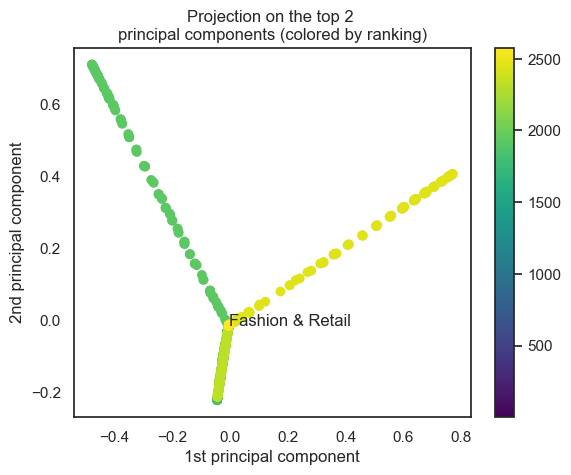

In [39]:
kernel_pca = KernelPCA(kernel="rbf" ,fit_inverse_transform=True, alpha=0.1)
kernel_score=kernel_pca.fit_transform(new_data)

ranking=13
fig, ax = plt.subplots()
sc=ax.scatter(kernel_score[:,0],kernel_score[:,1] ,c=y,cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.annotate(industrys[ranking], (kernel_score[ranking,0],kernel_score[ranking,1]))
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection on the top 2 \nprincipal components (colored by ranking)")
plt.show()

#### 5c. PCA only

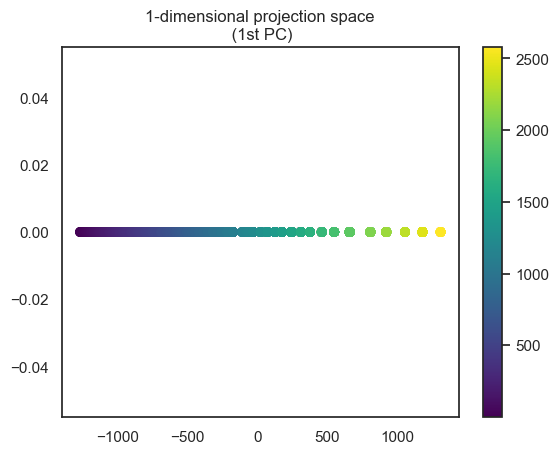

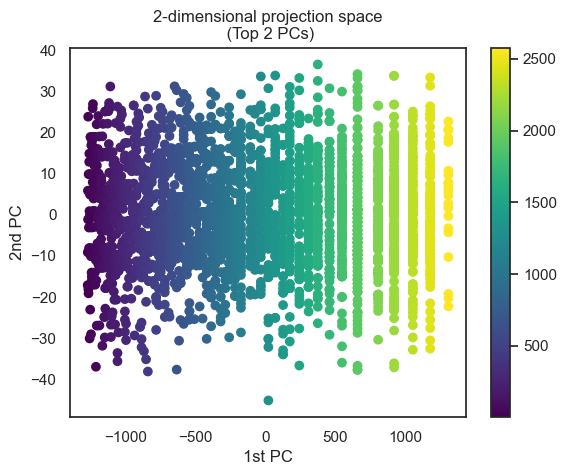

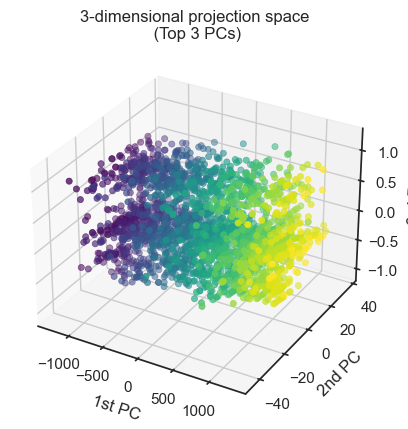

In [40]:
pca = PCA()
score_pca = pca.fit_transform(new_data)


fig, ax = plt.subplots()
sc=ax.scatter(score_pca[:,0],np.zeros(score_pca[:,1].shape ),c=y,cmap='viridis')
ax.set_title('1-dimensional projection space\n (1st PC)')
fig.colorbar(sc, orientation='vertical')
plt.show()


fig, ax = plt.subplots()
sc=ax.scatter(score_pca[:,0],score_pca[:,1] ,c=y,cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.set_title('2-dimensional projection space\n (Top 2 PCs)')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc=ax.scatter(score_pca[:,0], score_pca[:,1],  score_pca[:,2], c=y, cmap='viridis', linewidth=0.5);
ax.set_title('3-dimensional projection space\n (Top 3 PCs)')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()



#### 5d. Comparison

In [41]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(kernel_score, y, test_size=0.4, random_state=0)
lr = Ridge(alpha=0).fit(X_train, y_train)
print(str.format("Test set R^2 score for Kernel PCA: {}", lr.score(X_test, y_test)))

X_train, X_test, y_train, y_test = train_test_split(score_pca, y, test_size=0.40, random_state=0)
lr= Ridge(alpha=0).fit(X_train, y_train)
print(str.format("Test set R^2 score for PCA: {}", lr.score(X_test, y_test)))

Test set R^2 score for Kernel PCA: 0.9885118791786487
Test set R^2 score for PCA: 0.9997469018532432
